<a href="https://colab.research.google.com/github/Saurabh-Bagchi/datasharing/blob/master/Recommendation_Systems_Project_Saurabh_Bagchi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Recommendation Systems Project  
###Data Description:  
Amazon Reviews data (data source) The repository has several datasets. For this case study, we are using the Electronics dataset. 
####Domain: 
E-commerce 
####Context: 
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time. 
####Attribute Information: 
#####● userId  : Every user identified with a unique id 
#####● productId : Every product identified with a unique id \n 
#####● Rating  : Rating of the corresponding product by the corresponding user  
#####● timestamp : Time of the rating ( ignore this column for this exercise) 

####Learning Outcomes:  
● Exploratory Data Analysis 
● Creating a Recommendation system using real data 
● Collaborative filtering  

####Objective:  
Build a recommendation system to recommend products to customers based on the their  previous ratings for other products. 

####Steps and tasks: 
1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics) - (3 Marks) 
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) - (3 Marks) 
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (3 Marks) 
4. Build Popularity Recommender model. - (20 Marks) 
5. Build Collaborative Filtering model. - (20 Marks) 
6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7 Marks) 
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7 Marks) 
8. Summarise your insights. - (7 Marks) 

####References: 
#####● Recommeneder systems and its applications 
#####● Use cases of Recommendation systems 
● 

In [2]:
#Import the necessary libraries and mount to Google drive
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#Change to the drive location having the data file
os.chdir('/content/drive/My Drive')

In [4]:
#Read the csv file and assign column names as per problem statement description
ratings = pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])

In [5]:
#Check data snapshot to see if everything looks fine, timestamp column needs to be dropped later on
ratings.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
#Number of rows is 7.82MM and number of columns is 4
ratings.shape

(7824482, 4)

In [7]:
#Check the datatypes
#userID, productID are object while Rating is float, timestamp is integer
ratings.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [8]:
#The dataset is utilizing almost 240MB of disk space due to 7.82MM rows and 4 columns
#There will be memory issues unless we make the dataset more dense
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


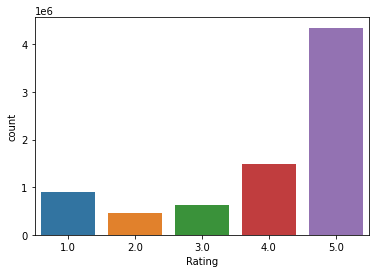

In [9]:
#Countplot of the ratings, maximum user-products have got rating as 5 
sns.countplot(data=ratings, x='Rating');
#ratings["Rating"].value_counts().sort_values(ascending=False).plot(kind="bar")

In [10]:
#Find the minimum and maximum ratings - It is between 1 and 5
print('Minimum rating is: %d' %(ratings.Rating.min()))
print('Maximum rating is: %d' %(ratings.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [11]:
#Check for missing values - There are no missing values, so no imputation required
print('Number of missing values across columns: \n',ratings.isna().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [12]:
#Number of products (~476K) is less than number of users(~4.2MM), so item-item colaborative filtering would make sense
#instead of user-user colaborative filtering
print("Electronic Data Summary")
print("="*100)
print("\nTotal # of Ratings :",ratings.shape[0])
print("Total # of Users   :", len(np.unique(ratings.userId)))
print("Total # of Products  :", len(np.unique(ratings.productId)))
print("\n")
print("="*100)

Electronic Data Summary

Total # of Ratings : 7824482
Total # of Users   : 4201696
Total # of Products  : 476002




In [13]:
#Dropping the Timestamp column
ratings.drop(['timestamp'], axis=1,inplace=True)

In [14]:
#Check and find the max ratings given by user for a particular item
max_ratings = ratings.groupby(['userId','productId'])['Rating'].max().sort_values(ascending=False)

In [15]:
max_ratings.head()

userId          productId 
A2W3PG4DZ3K3SW  B001T4K2FY    5.0
A2MB0EBSLPVFSR  B008S08ADI    5.0
                B000IEN8QQ    5.0
                B002G0CWSU    5.0
                B003SGCO3E    5.0
Name: Rating, dtype: float64

In [16]:
#Check and find the min ratings given by user for a particular item
min_ratings = ratings.groupby(['userId','productId'])['Rating'].min().sort_values(ascending=False)

In [17]:
min_ratings.head()

userId          productId 
A2W3PG4DZ3K3SW  B001T4K2FY    5.0
A2MB0EBSLPVFSR  B008S08ADI    5.0
                B000IEN8QQ    5.0
                B002G0CWSU    5.0
                B003SGCO3E    5.0
Name: Rating, dtype: float64

In [18]:
#From above min and max calculation, we see that the ratings are identical for the sample
#However for consistency let us remove duplicates if any just to be sure
ratings.drop_duplicates(inplace=True)

In [19]:
#Analysis of how many product rating given by a particular user 
no_of_rated_products_per_user = ratings.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [20]:
#We have certain users who have rated only 1 product and few users have rated upto 520 products
#However the number of rated products per user is fairly skewed
no_of_rated_products_per_user.describe().astype(int).T

count    4201696
mean           1
std            2
min            1
25%            1
50%            1
75%            2
max          520
Name: Rating, dtype: int64

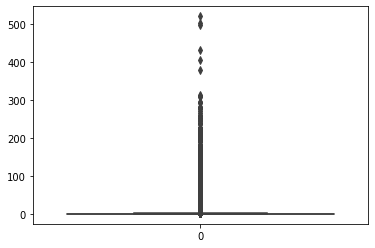

In [21]:
#Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items
sns.boxplot(data=no_of_rated_products_per_user);

In [22]:
#Let us look at the quantile view to understand where the ratings are concentrated
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

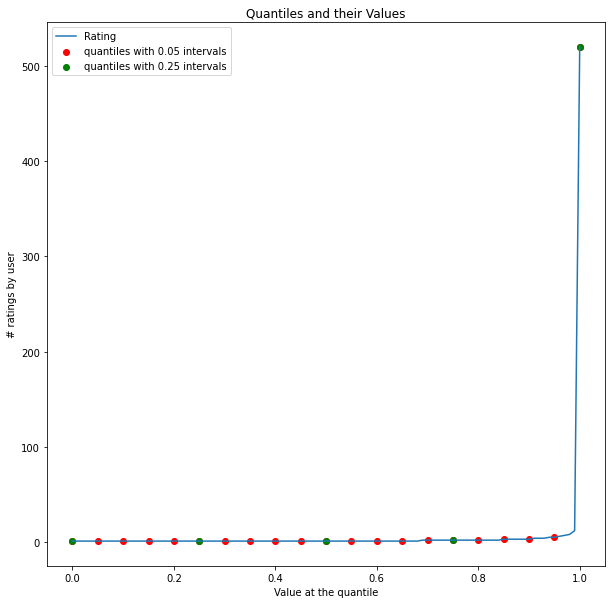

In [23]:
#We can see that all the ratings are clustered at the top end of the quantile
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [24]:
#We have 1,540 users who have rated more than or equal to 50 products
print('\n # of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 # of rated product more than 50 per user : 1540



In [25]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=ratings.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

<function matplotlib.pyplot.show>

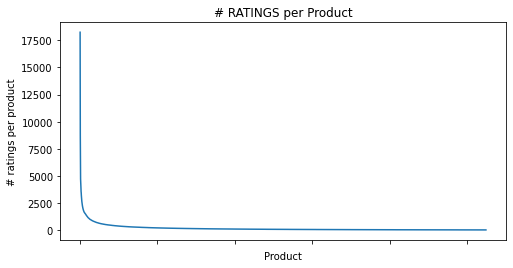

In [26]:
#Products also have skewed ratings with majority of the products having very few ratings
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('# ratings per product')
ax.set_xticklabels([])

plt.show

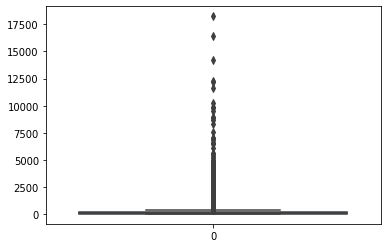

In [27]:
#Boxplot shows that we have few products with large number of ratings, but majority have very low ratings
sns.boxplot(data=no_of_ratings_per_product);

In [28]:
#Let us look at the quantile view to understand where the ratings are concentrated
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

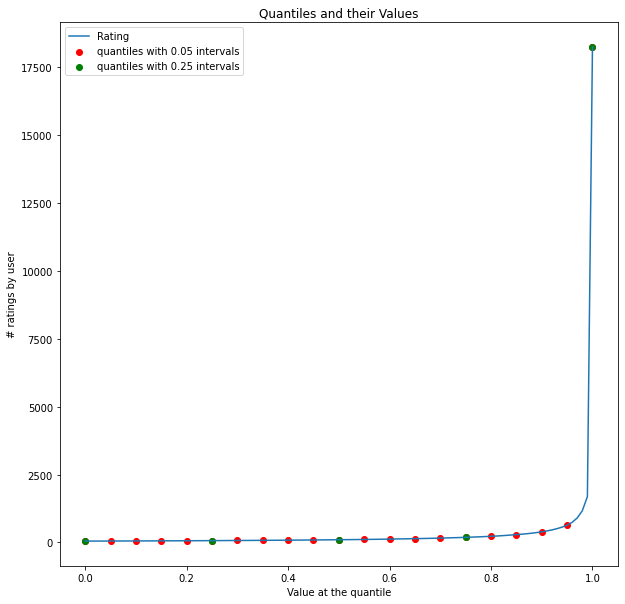

In [29]:
#We can see that all the ratings are clustered at the top end of the quantile
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [30]:
#Split the data into 70% train and 30% test
train_data, test_data = train_test_split(new_df, test_size = 0.30, random_state=0)
print(train_data.head(5))

                 userId   productId  Rating
154602   A15BHBF0L0HV1F  B000067RVL     5.0
3405827  A3VVJIZXLL1QFP  B003KPBRRW     5.0
1168365   AFHY3XJJ6NCAI  B000MM3EKY     5.0
2673404  A2WPY1SNQPCC00  B002L0VNXK     5.0
2175241   AJMJREC90WJVP  B001NJTZUS     4.0


In [31]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,0972683275,737
1,1400501466,178
2,1400501520,54
3,1400501776,93
4,1400532620,117


In [32]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])     
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
19245,B0074BW614,12760,1.0
25032,B00DR0PDNE,11573,2.0
20325,B007WTAJTO,9956,3.0
18581,B006GWO5WK,8541,4.0
6593,B0019EHU8G,8451,5.0


In [33]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [34]:
# This list is user choice, since this is popularity based recommendation method irrespective of user same products will be suggested
find_recom = ['A15BHBF0L0HV1F','A3VVJIZXLL1QFP','AFHY3XJJ6NCAI','A2WPY1SNQPCC00','AJMJREC90WJVP']   
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A15BHBF0L0HV1F

               userId   productId  score  Rank
19245  A15BHBF0L0HV1F  B0074BW614  12760   1.0
25032  A15BHBF0L0HV1F  B00DR0PDNE  11573   2.0
20325  A15BHBF0L0HV1F  B007WTAJTO   9956   3.0
18581  A15BHBF0L0HV1F  B006GWO5WK   8541   4.0
6593   A15BHBF0L0HV1F  B0019EHU8G   8451   5.0


Here is the recommendation for the userId: A3VVJIZXLL1QFP

               userId   productId  score  Rank
19245  A3VVJIZXLL1QFP  B0074BW614  12760   1.0
25032  A3VVJIZXLL1QFP  B00DR0PDNE  11573   2.0
20325  A3VVJIZXLL1QFP  B007WTAJTO   9956   3.0
18581  A3VVJIZXLL1QFP  B006GWO5WK   8541   4.0
6593   A3VVJIZXLL1QFP  B0019EHU8G   8451   5.0


Here is the recommendation for the userId: AFHY3XJJ6NCAI

              userId   productId  score  Rank
19245  AFHY3XJJ6NCAI  B0074BW614  12760   1.0
25032  AFHY3XJJ6NCAI  B00DR0PDNE  11573   2.0
20325  AFHY3XJJ6NCAI  B007WTAJTO   9956   3.0
18581  AFHY3XJJ6NCAI  B006GWO5WK   8541   4.0
6593   AFHY3XJJ6NCAI  B001

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [35]:
train_data_sort.head()
#print(pred)

,productId,score,Rank
19245,B0074BW614,12760,1.0
25032,B00DR0PDNE,11573,2.0
20325,B007WTAJTO,9956,3.0
18581,B006GWO5WK,8541,4.0
6593,B0019EHU8G,8451,5.0


In [36]:
test_data.head()

,userId,productId,Rating
5118933,AF4U3M94WEYPF,B005OLOIUI,5.0
5344739,A1IYQ5ZN1E5G1A,B0069SGO48,5.0
169991,A2KFD2ACBFPIL0,B00006B7DA,5.0
3789046,AQTKPXO5EPDED,B0041Q38NU,5.0
120206,A1YX4C6BH4RT12,B00005T3G0,5.0


In [37]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userId'],axis=1,inplace=True)
test_data2.rename(columns = {'Rating':'Act_rating'}, inplace = True)

In [38]:
test_data2.head()

,productId,Act_rating
5118933,B005OLOIUI,5.0
5344739,B0069SGO48,5.0
169991,B00006B7DA,5.0
3789046,B0041Q38NU,5.0
120206,B00005T3G0,5.0


In [39]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productId').agg({'Rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'Rating': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

,productId,Sum_rating
0,0972683275,3297.0
1,1400501466,642.0
2,1400501520,232.0
3,1400501776,352.0
4,1400532620,429.0


In [40]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)

In [41]:
train_data_inner.head()

,productId,Sum_rating,score,Rank
0,0972683275,3297.0,737,618.0
1,1400501466,642.0,178,4557.0
2,1400501520,232.0,54,16998.0
3,1400501776,352.0,93,9628.0
4,1400532620,429.0,117,7496.0


In [42]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]

In [43]:
train_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating
0,0972683275,3297.0,737,618.0,4.473541
1,1400501466,642.0,178,4557.0,3.606742
2,1400501520,232.0,54,16998.0,4.296296
3,1400501776,352.0,93,9628.0,3.784946
4,1400532620,429.0,117,7496.0,3.666667


In [44]:
#Merge the train data having avergae rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)

In [45]:
test_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,0972683275,3297.0,737,618.0,4.473541,5.0
1,0972683275,3297.0,737,618.0,4.473541,4.0
2,0972683275,3297.0,737,618.0,4.473541,5.0
3,0972683275,3297.0,737,618.0,4.473541,5.0
4,0972683275,3297.0,737,618.0,4.473541,5.0


In [46]:
#test_data_inner.reset_index()

In [47]:
#test_data_inner.drop(['index'],inplace=True,axis=1)

In [48]:
#Now the merged data has both actual rating (Act_rating) and predicted rating (Avg_rating)
#Now RMSE can be calculated
test_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,0972683275,3297.0,737,618.0,4.473541,5.0
1,0972683275,3297.0,737,618.0,4.473541,4.0
2,0972683275,3297.0,737,618.0,4.473541,5.0
3,0972683275,3297.0,737,618.0,4.473541,5.0
4,0972683275,3297.0,737,618.0,4.473541,5.0


In [49]:
#RMSE for popularity based recommender system is 1.27
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.2709033917453134


In [50]:
#Average rating of the product across users
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [51]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

In [52]:
#Total no of rating for product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [53]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [54]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [55]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [56]:
ratings_mean_count['rating_counts'].max()

18244

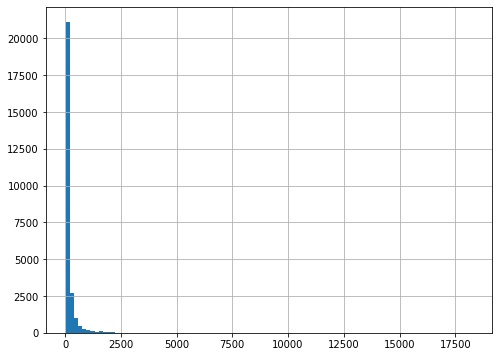

In [57]:
plt.figure(figsize=(8,6))
#plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=100)

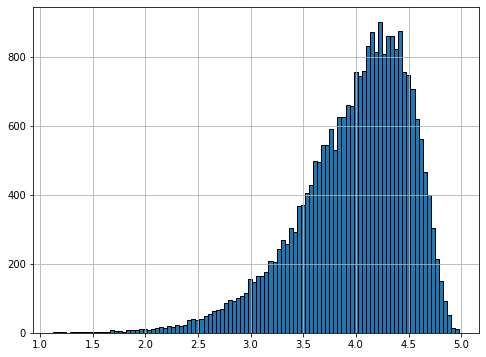

In [58]:
#We see a left skewed distribution for the ratings
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=100)

<Figure size 576x432 with 0 Axes>

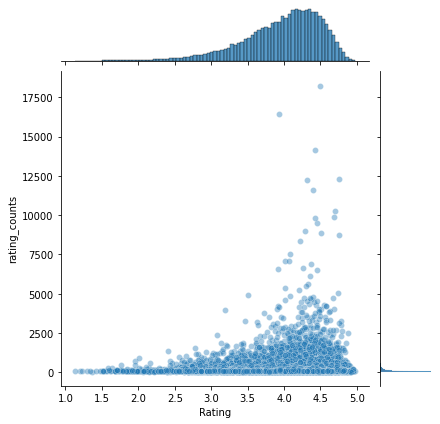

In [59]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
#To make people more engaged (bottom of the chart) we can start by recommending them based on popularity based system and then
#slowly graduate them to collaborative system once we have sufficient number of data points to giver personlized recommendation
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

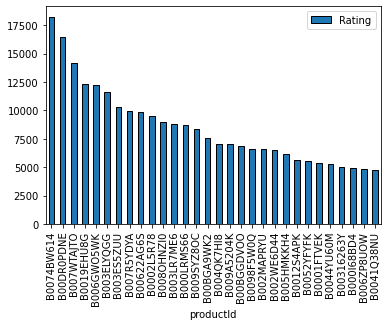

In [60]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [61]:
#Install surprise package for collaborative filtering
!pip install surprise

In [62]:
#Import all the relevant libraries from surprise package
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split as tts

In [63]:
ratings.shape

(7824482, 3)

In [64]:
#Getting the new dataframe which contains products which has 50 or more ratings
new_df2=ratings.groupby("userId").filter(lambda x:x['Rating'].count() > 50)

In [65]:
#We have 122K products which have more than 50 ratings
new_df2.shape

(122171, 3)

In [66]:
new_df2.head()

,userId,productId,Rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [67]:
#Getting the new dataframe which contains users who have given 50 or more ratings
new_df3=ratings.groupby("productId").filter(lambda x:x['Rating'].count() > 50)

In [68]:
new_df3.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [69]:
#We have about 5.35MM users who have rated at least 50 or more products
new_df3.shape

(5350913, 3)

In [70]:
#Drop ratng before final merge
new_df3.drop(['Rating'],inplace=True,axis=1)

In [71]:
#Final dataset which has users who have rated at least 50 products and products that have been rated by atleast 50 users
new_df4 = pd.merge(new_df2,new_df3)

In [72]:
new_df4.head()

,userId,productId,Rating
0,A3CLWR1UUZT6TG,0972683275,5.0
1,A3TAS1AG6FMBQW,0972683275,5.0
2,A25RTRAPQAJBDJ,0972683275,5.0
3,A3LDPF5FMB782Z,1400501466,5.0
4,A1A5KUIIIHFF4U,1400501466,1.0


In [73]:
#The new dataset has about 76K rows and 3 columns
#It is much easier to run KNN algorithm on this reduced dataset
new_df4.shape

(76359, 3)

In [74]:
#new_df4.rename(columns = {'raw_ratings':'Rating'}, inplace = True) 

In [75]:
new_df4.head()

,userId,productId,Rating
0,A3CLWR1UUZT6TG,0972683275,5.0
1,A3TAS1AG6FMBQW,0972683275,5.0
2,A25RTRAPQAJBDJ,0972683275,5.0
3,A3LDPF5FMB782Z,1400501466,5.0
4,A1A5KUIIIHFF4U,1400501466,1.0


In [76]:
#Reading the dataset
from sklearn.model_selection import train_test_split
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df4,reader)
#train_data, test_data = train_test_split(new_df4, test_size = 0.30, random_state=0)
#data_train = Dataset.load_from_df(train_data,reader)
#data_test = Dataset.load_from_df(test_data,reader)

In [77]:
#Split the data here only into 70% and 30%

In [78]:
#Splitting the dataset into 70% train and 30% test data
trainset, testset = tts(data, test_size=0.3,random_state=0)

In [79]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# For item-based we give user_based argument as false
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [80]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [81]:
test_pred

[Prediction(uid='A1VQBEW0G4IH1J', iid='B0028LK6IU', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B00ECERI32', r_ui=2.0, est=3.857142857142857, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADLVFFE4VBT8', iid='B004SD2562', r_ui=3.0, est=2.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1EH2S92FHWZRP', iid='B002VPE1XY', r_ui=5.0, est=4.080534535765993, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1PAGHECG401K1', iid='B003ZTWYXY', r_ui=4.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AD0J5KK4WQXNS', iid='B000HAR8UI', r_ui=5.0, est=4.333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B0000658CH', r_ui=5.0, est=3.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A26KXNN6H1IL0I', iid='B003E2VLYA', r_ui=5.0, est=4.298160932442798, details={'was_impossible'

In [82]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1211


1.1210884014038527

In [83]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 5.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [84]:
#Get the top 5 items for each user
top_n = get_top_n(test_pred, n=5)

In [85]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1VQBEW0G4IH1J ['B0028LK6IU', 'B00GHY5F3K', 'B00BQ5RY1G', 'B004CLYEFK', 'B0039NLS3I']
A3OXHLG6DIBRW8 ['B00461E7JE', 'B0000510T7', 'B000FQ2JLW', 'B0093AN1OA', 'B00012FVYC']
ADLVFFE4VBT8 ['B004MSI7UQ', 'B0011FQUUW', 'B00L3YHF6O', 'B008YRG5JQ', 'B007M506WS']
A1EH2S92FHWZRP ['B0025PKFUI', 'B000PO3CTM', 'B00000J4FS', 'B002KANXBG', 'B00FRMAOIO']
A1PAGHECG401K1 ['B003ZTWYXY', 'B0036OR91A', 'B00BOZCUG2', 'B007M58WWO', 'B005J7YA4G']
AD0J5KK4WQXNS ['B0007NIJBC', 'B0002ED4PM', 'B000051SGX', 'B000HAR8UI', 'B00007KDVI']
A231WM2Z2JL0U3 ['B000028F42', 'B0000630TO', 'B00007K3A3', 'B00005B8HO', 'B00005AC8J']
A26KXNN6H1IL0I ['B003TJALAI', 'B000RZ8WHG', 'B003Q0BPC8', 'B000VWPULQ', 'B0012Y541S']
A3JU990UTN5RQP ['B003VSTDFG', 'B0078GCLRY', 'B006HUMYCO', 'B002YU83YO', 'B003SX0OR0']
A105TOJ6LTVMBG ['B003MB0WMA', 'B00135IILO', 'B0019EHU8G', 'B004W2BAXI', 'B00029U1DK']
A25WJCAP606YMP ['B0006Q3B2W', 'B0055Q2VNI', 'B00180LGX6', 'B00BG5M93Y', 'B00ALN54KM']
A1TDR7Y90SVCHL ['B003SX0O2K', 'B001K7I62Q', 'B00BCPIFC2',

In [ ]:
#We have made both popularity and collaborative recommendation system here
#Popularity based system had RMSE of 1.27 while collaborative item-item based system had RMSE of 1.21
#So the collaborative item-item based recommendation system was slighlty better although we had to create a more dense matrix
#This shows that popularity based and collaborative item-item based system are comparable if user ratings are skewed to few items only
#The dense matrix consists of users who have rated atlest 50 products and products having at least 50 ratings
#This was done to avoid system crashes and restrict the recommendation to the top users for collaboratibve filtering as it is computation intensive
#For the rest of the portfolio we can have popularity based recommendations as they are not that much engaged with electronic products
#We can also use hyperparameter tuning to get better results in terms of RMSE but unfortunately surprise package is giving errors
#if the testset dimension is different than the training set (uploaded as issue to Olympus portal),
#Further improvement can be made by doing GridSearchCV or RandomSearchCV to understand what is the best k to reduce RMSE
#We are not able to plot distortion vs K value as Surprise package converts dataframe into a different format


Computing the cosine similarity matrix...
